# STAT 201 Project Proposal

# 0 - Introduction

In Canada, cancer is currently the leading cause of death annually with 2 in 5 people expected to be diagnosed once in their lifetime (Canadian Cancer Statistics, 2021), and gliomas being the most common malignant tumors in adults (Carrano, 2021). There exists certain genetic mutations that can increase the risk of cancer, accelerating cancer progression, such as the epidermal growth factor receptor (EGFR) (Xu, 2017). As EGFR mutations are more commonly associated with lung cancer, investigating the impacts of EGFR gene mutations on the severity of gliomas may also be useful for other clinical treatments and therapies (Liu, 2020). Another factor commonly associated to prognosis is the age of diagnosis. Therefore our interests are two-fold:

1) Do the proportion of patients with the EGFR mutation differ between those with glioblastoma (GBM) and low grade glioma (LGG)?

2) Is there a significant difference in the average age of diagnosis for individuals with glioblastoma (GBM) and low grade glioma (LGG)?

The dataset we will be using is the Glioma Grading Clinical and Mutation Features Dataset from the UCI Machine Learning Repository. For our purposes, we are interested in the following features. 

For the first question:
  
* `EGFR`: Gene responsible for the production of the epidermal growth factor receptor (EGFR) (0 = not mutated, 1 = mutated)
* `Grade`: Glioma class information (1 = glioblastoma (GBM), 0 = low grade glioma (LGG))

For the second question:

* `Age_at_diagnosis`: age of individual at time of diagnosis in years
* `Grade`: Glioma class information (1 = glioblastoma (GBM), 0 = low grade glioma (LGG))


# 1 - Methods and Results

For our analysis, we will perform a two-sided hypothesis test for both of our questions to estimate the difference in means and the difference in proportions for each corresponding question. From that we will decide whether or not to accept or reject the null based on the p-value, and then the 95% confidence interval for the true parameter will be calculated. Below are the preliminary results found in the initial investigation. It should be noted that the conditions for ***Central Limit Theorem (CLT)*** are fulfilled: 

1. with 10000 samples of size 839, there will be sufficent sample size for CLT
2. For question 2, since the following statments are true CLT can apply 

    A) $839\times\min(1-0.06359671, 0.06359671)\ge10$ and $839\times\min(1-0.2303014,0.2303014)\ge10$
   
    B) $352\times\min(1-0.06359671, 0.06359671)\ge10$ and $352\times\min(1-0.2303014,0.2303014)\ge10$
    
    C) $487\times\min(1-0.06359671, 0.06359671)\ge10$ and $487\times\min(1-0.2303014,0.2303014)\ge10$
    


## 1.1 - Preliminary Results

In [1]:
library(tidyverse)
library(infer)
library(cowplot)
library(stringr)
library(broom)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp




In [2]:
glioma_raw <- read_csv("https://raw.githubusercontent.com/Lucien950/stat-201-group-15/main/TCGA_InfoWithGrade.csv")

Rows: 839 Columns: 24
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (24): Grade, Gender, Age_at_diagnosis, Race, IDH1, TP53, ATRX, PTEN, EGF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 1.1.1 - Explanation of the Datset
The dataset is that of glioma patients. The clinical features are `Gender`, `Age_at_diagnosis` and `Race`, and there are a variety of binary features, whether a specific gene is mutated or not. The grade of the glioma is encoded in the `Grade` feature. A preview of the dataset is shown below.

In [3]:
head(glioma_raw)

Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,⋯,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,51.30,0,1,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
0,0,38.72,0,1,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,35.17,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,32.78,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
0,0,31.51,0,1,1,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,33.21,0,1,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### 1.1.2 - Data Preprocessing

In [4]:
# Wrangling data to filter out unknowns and select variables of interest
glioma <- glioma_raw %>%
    filter(!is.na(Age_at_diagnosis),
           !is.na(Grade),
           !is.na(Gender),
           !is.na(EGFR)) %>%
    select(Grade, Gender, Age_at_diagnosis, EGFR)

head(glioma)

Grade,Gender,Age_at_diagnosis,EGFR
<dbl>,<dbl>,<dbl>,<dbl>
0,0,51.30,0
0,0,38.72,0
0,0,35.17,0
0,1,32.78,0
0,0,31.51,0
0,1,33.21,0


In [5]:
#Finding number of Grade 0, Grade 1 and total number observations
summary <- glioma %>%
group_by(Grade) %>%
summarize(count = n())

data_summary <- tibble("Number of Grade 0 Patients" = summary$count[1],
                       "Number of Grade 1 Patients" = summary$count[2],
                       "Total Number of Observations" = nrow(glioma))
data_summary

Number of Grade 0 Patients,Number of Grade 1 Patients,Total Number of Observations
<int>,<int>,<int>
487,352,839


### 1.1.3 - Project Questions
In this study we are interested in two things:  
1. Is there a difference in the proportions of patients with EGFR gene mutation between high grade and low grade groups?
2. Is there a difference in the average age of diagnosis between high grade and low grade glioma?

#### Preliminary Results for Question 1 - EGFR Mutation Proportions and Glioma Grade

In [6]:
set.seed(1)
# Create a bootstrap distribution of mutated EGFR gene proportions 
egfr_virtual_bootstrap_dist <- glioma %>%
    mutate(EGFR = as.factor(EGFR)) %>%
    specify(response = EGFR, success = '1') %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'prop') 

# Create a bootstrap distribution of mutated EGFR gene proportions of the low-grade glioma 
egfr_virtual_samples_0 <- glioma %>%
    filter(Grade == 0) %>%
    mutate(EGFR = as.factor(EGFR)) %>%
    specify(response = EGFR, success = '1') %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'prop') %>%
    cbind(Grade = rep(0, 10000))

# Create a bootstrap distribution of a mutated EGFR gene proportions of the high-grade glioma
egfr_virtual_samples_1 <- glioma %>%
    filter(Grade == 1) %>%
    mutate(EGFR = as.factor(EGFR)) %>%
    specify(response = EGFR, success = '1') %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'prop') %>%
    cbind(Grade = rep(1, 10000))

# Combine the two bootstrap distributions into one dataframe 
egfr_virtual_samples_by_label <- rbind(egfr_virtual_samples_0, egfr_virtual_samples_1) %>%
    mutate(Grade = as.factor(Grade))

Generate plots for the samples generated above

In [7]:
# The plot of bootstrap samples by label
plot_by_label <- egfr_virtual_samples_by_label %>%
    ggplot() + 
    geom_histogram(aes(x = stat, fill = Grade), bins = 40) + 
    xlab("Proportion of EGFR Mutations of Bootstrap Samples") + 
    ggtitle("Bootstrap Distribution of EGFR Mutation Proportions by Glioma Grade") + 
    theme(text = element_text(size = 16))

# The plot of bootstrap samples holistically 
plot_entire <- egfr_virtual_bootstrap_dist %>%
    ggplot() + 
    geom_histogram(aes(x = stat), bins = 40) + 
    xlab("Proportion of EGFR Mutations of Bootstrap Samples") + 
    ggtitle("Bootstrap Distribution of EGFR Mutation Proportions by Glioma Grade") + 
    theme(text = element_text(size = 16))

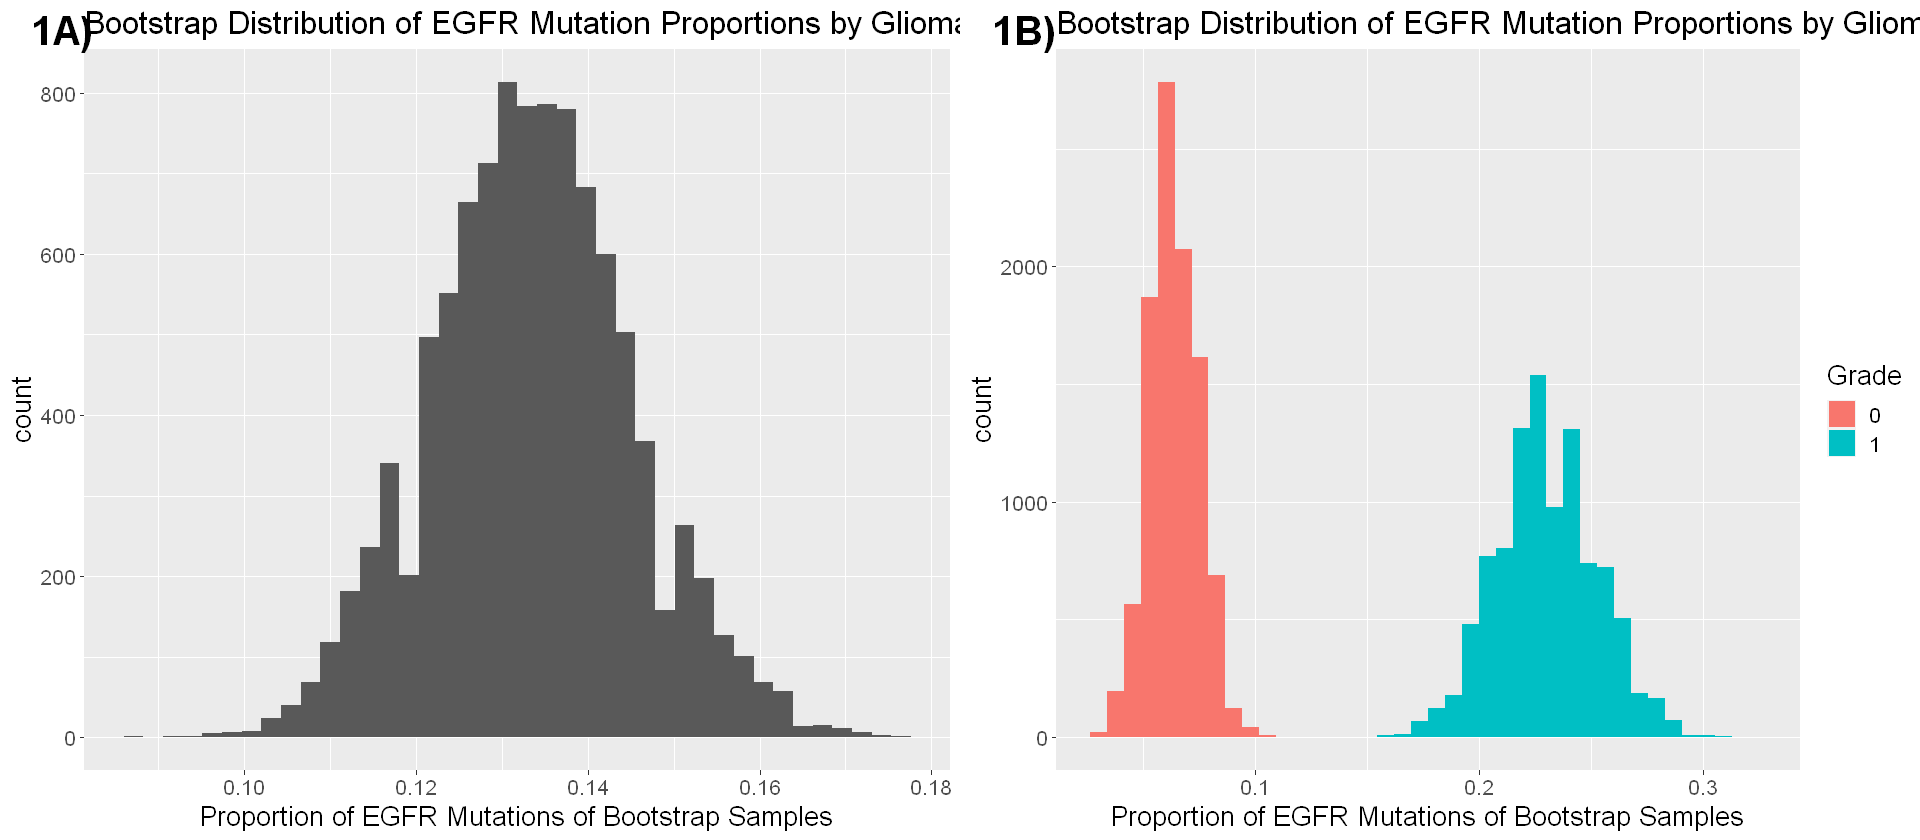

In [8]:
# Plot by grid
options(repr.plot.width = 16)
plot_grid(plot_entire, plot_by_label, labels = c('1A)', '1B)'), label_size = 24) 

**Figure 1A:** The bootstrap distribution of proportions of EGFR mutations in glioma patients. The mean is around 14%, with approximately 14% of glioma patients have an EGFR gene mutation.  
**Figure 1B:** The bootstrap distribution of proportions of EGFR mutations in low grade vs high grade glioma patients. The mean for low-grade glioma patients is roughly 7%, and the mean for high-grade glioma patients is roughly 24%. This may suggest that EGFR mutations are associated with higher-grade glioma.

#### Preliminary Results for Question 2 - Patient Age at Diagnosis and Glioma Grade

In [9]:
set.seed(1)
# Create a bootstrap distribution of mutated EGFR gene proportions of the low-grade glioma 
age_virtual_samples_0 <- glioma %>%
    filter(Grade == 0) %>%
    specify(response = Age_at_diagnosis) %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'mean') %>%
    cbind(Grade = rep(0, 10000))

# Create a bootstrap distribution of a mutated EGFR gene proportions of the high-grade glioma
age_virtual_samples_1 <- glioma %>%
    filter(Grade == 1) %>%
    specify(response = Age_at_diagnosis) %>%
    generate(type = 'bootstrap', reps = 10000) %>%
    calculate(stat = 'mean') %>%
    cbind(Grade = rep(1, 10000))

# Combine the two bootstrap distributions into one dataframe 
age_virtual_samples <- rbind(age_virtual_samples_0, age_virtual_samples_1) %>%
    mutate(Grade = as.factor(Grade))

Generate the resulting plots for the samples generated above with the `infer` package workflow. 

In [10]:
# Sample distribution plot of age at diagnosis
age_sample_dist <- glioma %>%
    filter(!is.na(Age_at_diagnosis)) %>%
    mutate(Grade = as.factor(Grade)) %>%
    ggplot() + 
    geom_histogram(aes(x = Age_at_diagnosis, fill = Grade), alpha = 0.75, bins = 39) + 
    xlab("Age of Diagnosis") + 
    ggtitle("Sample Distribution of Age at Diagnosis of Glioma") +
    theme(text = element_text(size = 16))

# Plot the resulting bootstrap distributions
mean_age_bootstrap_dist <- age_virtual_samples %>%
    ggplot() + 
    geom_histogram(aes(x = stat, fill = Grade), bins = 35) + 
    xlab("Mean Age at Diagnosis of Bootstrap Samples") + 
    ggtitle("Bootstrap Distribution of Age at Diagnosis by Glioma Grade") + 
    theme(text = element_text(size = 16))

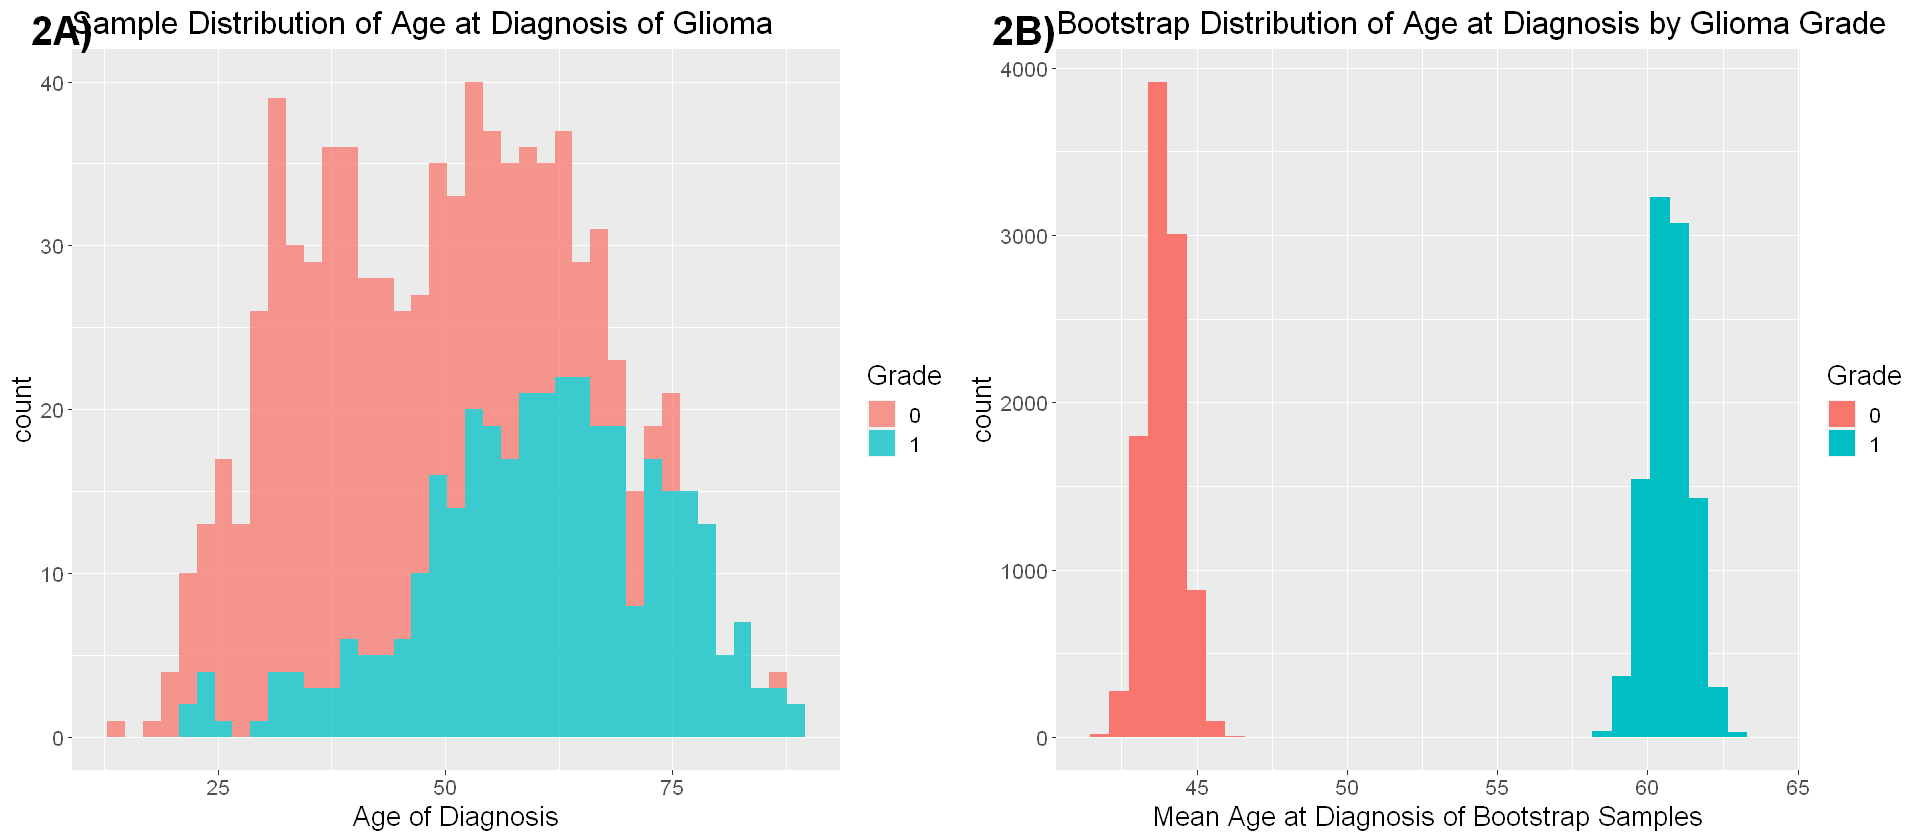

In [11]:
options(repr.plot.width = 16)
plot_grid(age_sample_dist, mean_age_bootstrap_dist, labels = c('2A)', '2B)'), label_size = 24)

**Figure 2A:** The sample distribution of patients ages at the time of glioma diagnosis as encoded in the `Age_at_diagnosis` feature. The histograms are color coded by the glioma grade, where the red histogram indicates low grade glioma, and the cyan histogram displays the distribution of high grade glioma. The purpose of this visualization is to explore whether the sample distribution of patient age at diagnosis reveals anything about their glioma grade. For example, patients diagnosed at a later age may have a higher grade glioma. The distribution has quite a wide range, ranging from about 12 to over 85 years of age. We see majority of the high-grade glioma diagnoses are on the higher end of the distribution, whereas the lower grade gliomas are spread across in what seems to be a bimodal distribution.  
**Figure 2B:** The bootstrap distribution of patients mean age taken from 10,000 bootstrap samples. The mean age of diagnosis for patients with low grade glioma seems to be around 44, and the mean age of diagnosis for high grade glioma patients is around 61. 

### 1.1.4 - Summary of Test Statistics of Interest

In [12]:
egfr_bootstrap_mean_0 <- mean(egfr_virtual_samples_0$stat)
egfr_bootstrap_mean_1 <- mean(egfr_virtual_samples_1$stat)
age_bootstrap_mean_0 <- mean(age_virtual_samples_0$stat)
age_bootstrap_mean_1 <- mean(age_virtual_samples_1$stat)

In [13]:
summary.stat.table <- tibble(
    "Low-grade Glioma Patients" = c(egfr_bootstrap_mean_0, age_bootstrap_mean_0),
    "High-grade Glioma Patients" = c(egfr_bootstrap_mean_1, age_bootstrap_mean_1), 
    "Rownames" = c("Proportion EGFR Mutated (p)", "Age of Diagnosis (a)")
    )
summary.stat.table <- summary.stat.table %>%
    column_to_rownames(., var = 'Rownames')
summary.stat.table

,Low-grade Glioma Patients,High-grade Glioma Patients
,<dbl>,<dbl>
Proportion EGFR Mutated (p),0.06359671,0.2303014
Age of Diagnosis (a),43.87730392,60.7097155


At first glance, it seems there is a difference between the low-grade and high-grade glioma patients. To confirm, we will perform hypothesis testing with the following null hypotheses:  
Test one: the proportion of patients with EGFR mutations, $p$:  
* $H_0$: $p_{low-grade} = p_{high-grade}$  
* $H_A$: $p_{low-grade} \neq p_{high-grade}$  

Test two: the age of diagnosis, $a$:
* $H_0$: $\bar x_{low-grade} = \bar x_{high-grade}$
* $H_A$: $\bar x_{low-grade} \neq \bar x_{high-grade}$

#### Based on preliminary results, the following patterns are visible: 
1. The proportion of GBM patients with EGFR mutation > proportion of LGG patients with EGFR mutation
2. At the time of diagnosis, the mean age of GBM patients > the mean age of LGG patients  

#### Expected Findings
With hypothesis testing, it can be stated that these factors are correlated with glioma grade. The significance of this study is three-fold. First, this may provide an entry-point to genetic and metabolic studies to better understand the pathophysiology of glioma. Second, the tests regarding age at time of diagnosis may contribute to understanding people who may be at higher risk and how the disease develops. Lastly, studying these factors can contribute to screening methods for early detection and better patient prognsis. 

#### For the actual hypothesis testing the following procedure will be used:

For the first question, is there a difference in proportion of those with the EGFR mutation between individuals with high grade versus low grade glioma, we have opted to use a bootstrap analysis. Although with this sample, this analysis could be done using CLT since it follows the $np > 10$ and $n(1-p) > 10$ rules, however since this case is close to the borderline with $np = 21$ for low grade glioma paitients with the EGFR mutations, we decided to use bootstrapping instead for a more reliable and simpler analysis. 

The following steps will be used:

1. Using the infer workflow, calculate the difference in proportion from the sample

2. Generate a simulated population assuming the null hypothesis is true, so the difference in proportions of the sampling distribution is ceneter around 0

3. Visulaize this distribution and calculate the p-value using the test statistic from before 

4. Based on the p-value and our sigificance level of 0.05, we can either accept or reject the null hypothesis and calculate a 95% confidence interval of the true population difference in proportions

For the second question, is there a difference in the average age of diagnosis for the low grade and high grade glioma patients, we decided to use CLT analysis since we have a large enough sample size so the sampling distibution of the difference in means should converge to the normal distribution. However, since we do not have access to the population standard deviation, we will use the t-distribution to estimate the p-value and confidence intervals. 

To perform this analysis, the following steps will be used:

1. First find the sample statistics for each grade like number of observations, the mean and the standard deviation for each group.

2. Find the observed difference in means from the sample and calculate the pooled variance.

3. Calculate the t-test statistic using the observed difference in means and pooled variance

4. Since the population standard deviation is unknown, we must find the degrees of freedom using the formula,

$$
df = \frac{(\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2})^2}
{(\frac{1}{n_1-1})*(\frac{s_1^2}{n_1})^2+(\frac{1}{n_2-1})*(\frac{s_2^2}{n_2})^2}
$$  

5. Calculate the p-value approximating with the t-distribution by using the pt() function and the observed test statistic and the degrees of freedom

## 1.2 - Hypothesis Testing

### 1.2.1 - Using a Shuffled Sampling Distribution to Test Differences in Proportions of Patients with EGFR Mutation in High-Grade Glioma Cohort vs Low-Grade Glioma Cohort

Here we use a permutation sampling distribution, or a simulation-based approach to test our hypotheses for **Question 1**, which is interested in whether there is a difference between the proportion of patients that have EGFR mutations in the high-grade glioma cohort compared to the low-grade glioma cohort. The next code cell generates the shuffled sampling distribution, to generate the null distribution and run the hypothesis test.

In [14]:
set.seed(1)

# Converting numeric variable to factors, then calculating test statistic
bootstrap_glioma <- glioma %>%
    mutate(Grade= factor(Grade)) %>%
    mutate(EGFR= factor(EGFR)) 

# Observed test statistic
proportion_test_stat<- bootstrap_glioma %>% 
    specify(EGFR~ Grade, success= "1")%>%
    calculate(stat= "diff in props", order= c("1","0")) %>%
    pull()

# Generating simulation based population
null_dist <- bootstrap_glioma %>%
    specify(EGFR ~ Grade, success= "1") %>%
    hypothesize(null="independence") %>%
    generate(reps=10000, type= "permute") %>%
    calculate(stat= "diff in props", order= c("1","0"))

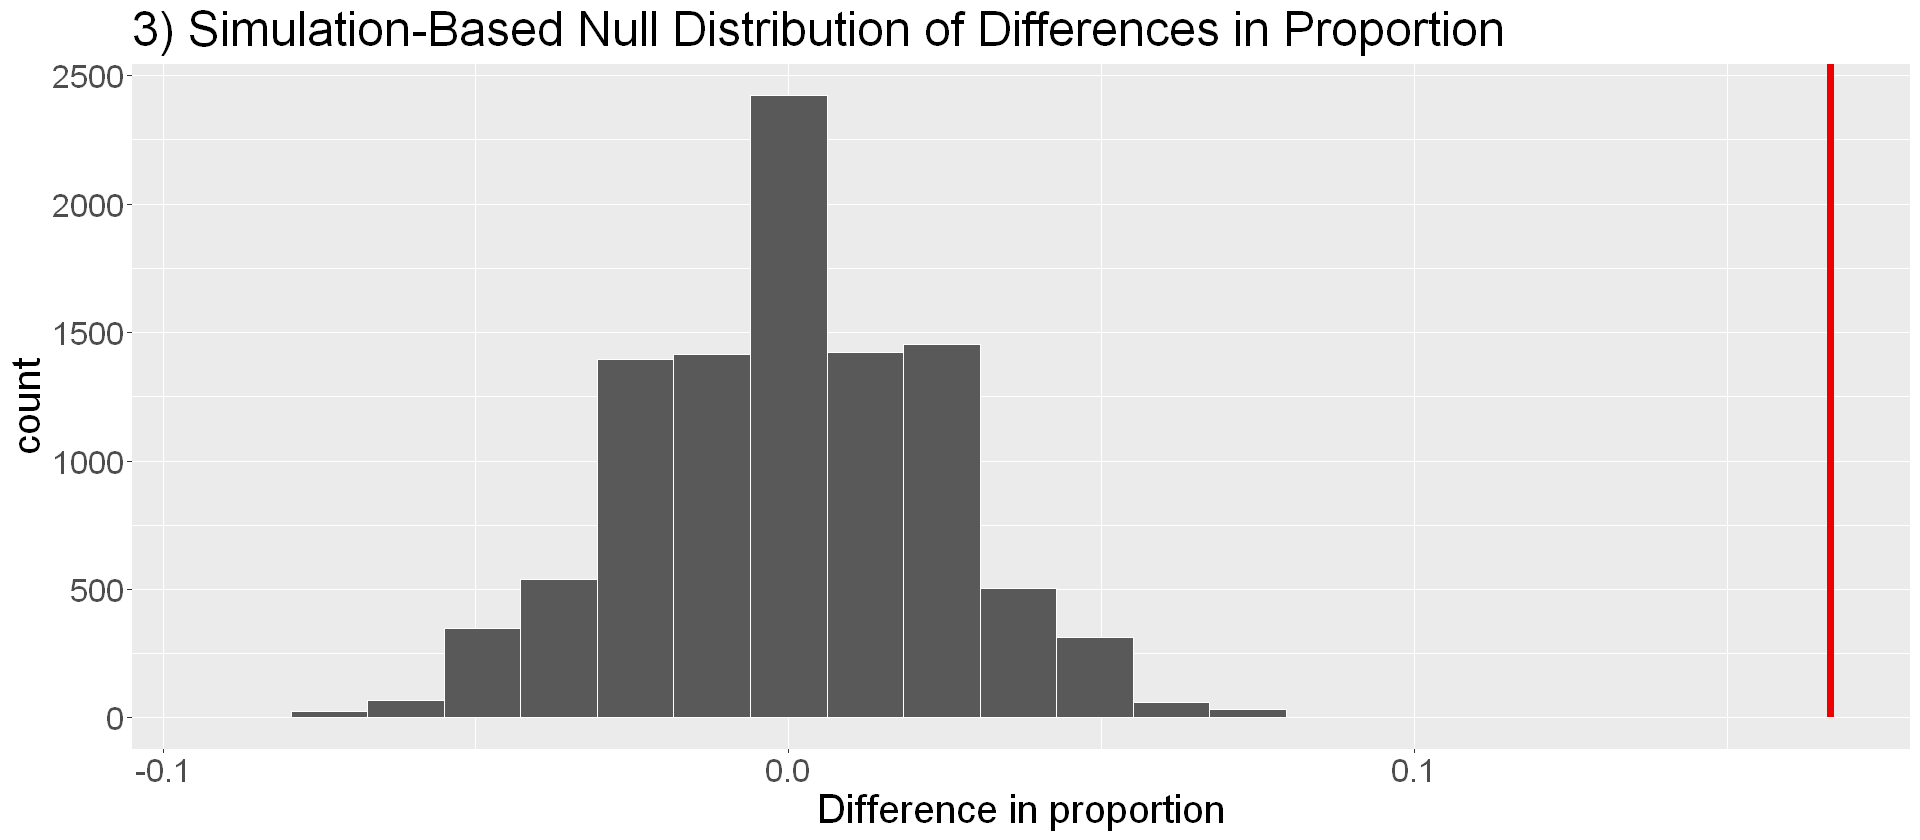

In [15]:
# Visualizing simulated distribution and shading the p-value using test statistic
options(repr.plot.width = 16)
prop_test_dist <- null_dist %>%
    visualize(binwidth = 1) +
    ggtitle("3) Simulation-Based Null Distribution of Differences in Proportion") + 
    shade_p_value(obs_stat = as.numeric(proportion_test_stat), direction = "both")+
    xlab("Difference in proportion") + 
    theme(text = element_text(size = 24))
prop_test_dist

**Figure 3:** The bootstrap distribution of the difference in proportions, assuming the null hypothesis is true. The p-value is indicated by the red line and since it lies completely seperate from the distribution it indicates very low probability that the true difference in proportion will follow the null hypothesis

In [16]:
# Finding numeric p-value
p_value <- null_dist %>%
    get_p_value(obs_stat = as.numeric(proportion_test_stat), direction = "two_sided")

p_value

Warning message:
"Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information."


p_value
<dbl>
0


Now that we have the p-value, compute the 95% confidence interval of the difference in proportions.

In [17]:
set.seed(1)

# Creating a bootstrap distribution of the sample difference in proportion
bootstrap_dist <- bootstrap_glioma %>%
    specify(EGFR ~ Grade, success= "1") %>%
    generate(reps=10000, type= "bootstrap") %>%
    calculate(stat= "diff in props", order= c("1","0")) 

# Calculating a 95% confidence interval for the true difference in proportion
ci <- bootstrap_dist %>%
    get_ci()
ci

lower_ci,upper_ci
<dbl>,<dbl>
0.1181648,0.2153274


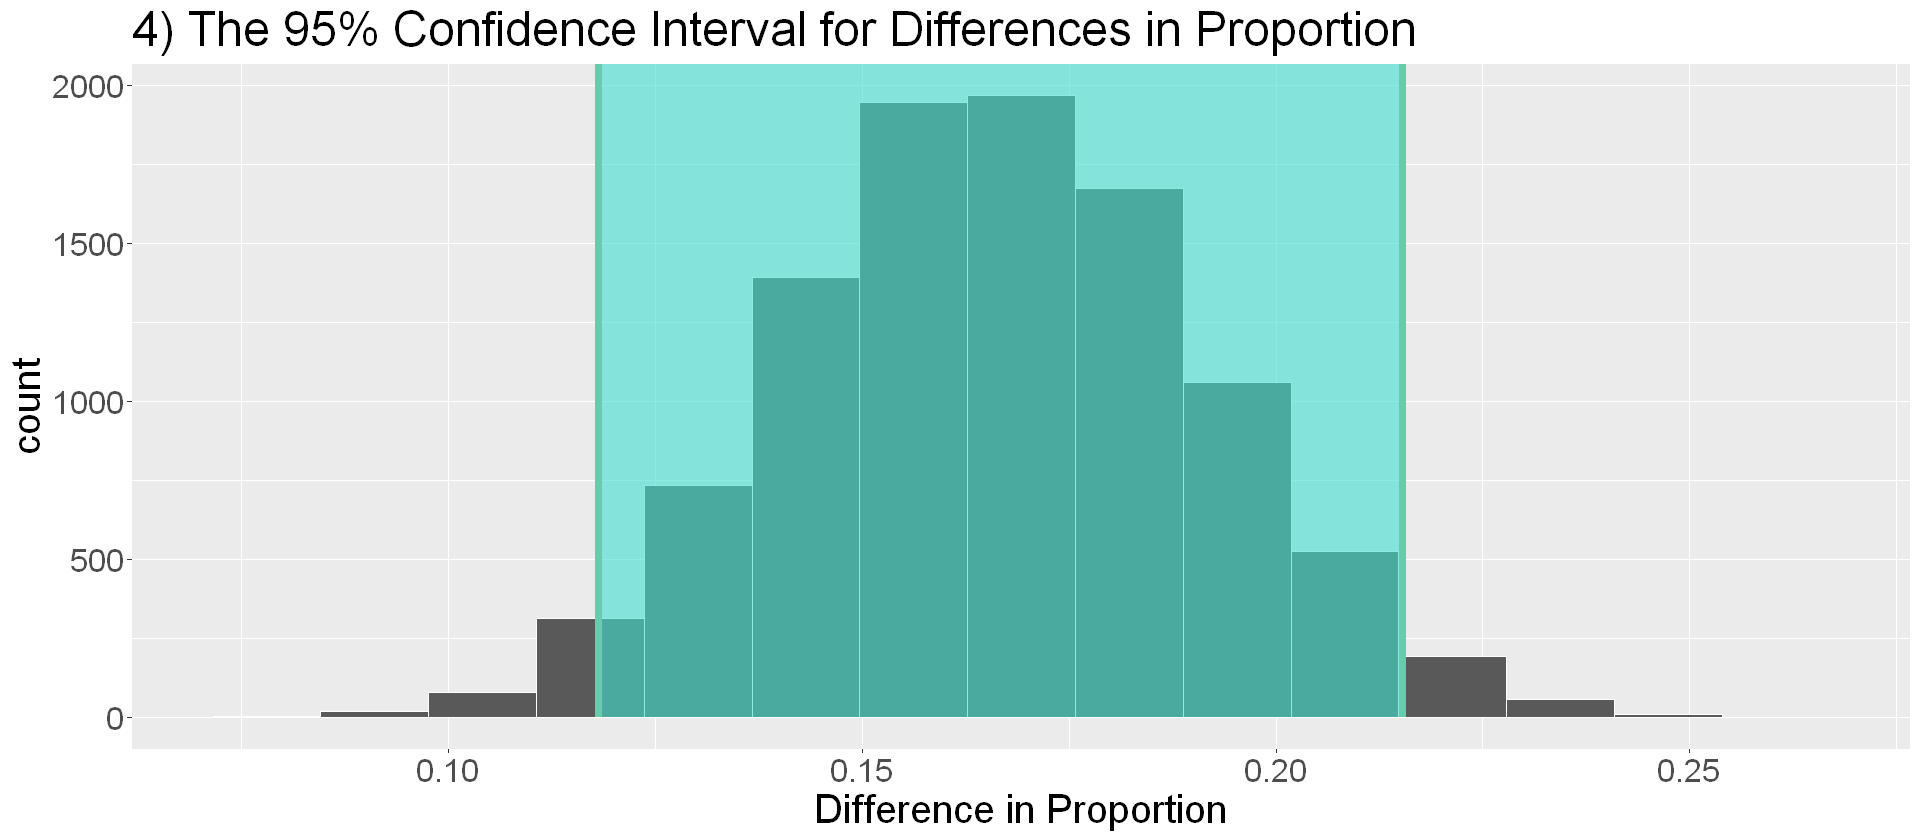

In [18]:
options(repr.plot.width = 16)
bootstrap_dist_plot <- bootstrap_dist %>%
    visualize() +
    ggtitle("4) The 95% Confidence Interval for Differences in Proportion") +
    shade_ci(endpoints = ci) + 
    xlab("Difference in Proportion") + 
    theme(text = element_text(size = 24))

bootstrap_dist_plot

**Figure 4:** Bootstrap distribution of the actual difference in proportion between the two populations with the 95% confidence interval shaded.

**Results For Question 1**  
diff = Difference in proportions of high-grade glioma patients with EGFR patients and low-grade glioma patients with EGFR patients  
$diff = 0.166 \pm 0.049$

### 1.2.2 - Using Theory-Based Methods to Test Difference in Mean Age at Diagnosis for Low-Grade Glioma Patients and High-Grade Glioma Patients

In [19]:
alpha <- 0.05

In [20]:
# Calculating summary statistics for each grade
t2_summary <- glioma %>%
    group_by(Grade) %>%
    summarize(grade_n = n(), age_mu = mean(Age_at_diagnosis), age_sd = sd(Age_at_diagnosis))

# Storing values for each grade is separate objects
t2_grade_0_summary <- t2_summary[1, ]
t2_grade_1_summary <- t2_summary[2, ]

# Calculating the difference in means and the pooled variance
t2_diff_mean <- t2_grade_0_summary$age_mu - t2_grade_1_summary$age_mu
t2_var <- t2_grade_0_summary$age_sd^2 / t2_grade_0_summary$grade_n + t2_grade_1_summary$age_sd^2 / t2_grade_1_summary$grade_n

# Calculating t-test statistic
t2_T <- t2_diff_mean / sqrt(t2_var)

# Finding the degrees of freedom for two populations with unknown standard deviations
t2_df <- t2_var^2 / (t2_grade_0_summary$age_sd^4 / (t2_grade_0_summary$grade_n^2 * (t2_grade_0_summary$grade_n - 1)) + t2_grade_1_summary$age_sd^2 / (t2_grade_1_summary$grade_n^2 * (t2_grade_1_summary$grade_n - 1)))

#Calculating the p-value using the t-distribution with the test statistic and degrees of freedom
t2_p <- 2 * pt(t2_T, t2_df, lower.tail = T)

In [21]:
print(str_glue("With a t-value of {t2_T}, a p_value of {t2_p} was found"))
print(str_glue("This is{if(t2_p < alpha) '' else ' not'} more significant than the {alpha} set as the significance level"))

With a t-value of -18.0081276241434, a p_value of 1.09453670541347e-68 was found
This is more significant than the 0.05 set as the significance level


In [22]:
# Finding the confidence intervals for average age of diagnosis for each grade of glioma
ci_grade0 <- t2_grade_0_summary %>%
    summarize(
        lower_ci = qt(0.05, t2_df) * age_sd / sqrt(grade_n) + age_mu,
        upper_ci = qt(0.95, t2_df) * age_sd / sqrt(grade_n) + age_mu
    ) %>%
mutate(grade = 0)

ci_grade1 <- t2_grade_1_summary %>%
    summarize(
        lower_ci = qt(0.05, t2_df) * age_sd / sqrt(grade_n) + age_mu,
        upper_ci = qt(0.95, t2_df) * age_sd / sqrt(grade_n) + age_mu
    ) %>%
mutate(grade = 1)

In [23]:
ci_summary <- rbind(ci_grade0, ci_grade1)
ci_summary

lower_ci,upper_ci,grade
<dbl>,<dbl>,<dbl>
42.88613,44.86372,0
59.52619,61.88131,1


In [24]:
t2_summary

Grade,grade_n,age_mu,age_sd
<dbl>,<int>,<dbl>,<dbl>
0,487,43.87493,13.26173
1,352,60.70375,13.42708


**Results of Question 2**  
$\mu_{low-grade} = 43.87 \pm 0.989$  
$\mu_{high-grade} = 60.70 \pm 1.18$

# 2 - Discussion

**Summary of Results**  
For our [first question](#1.1.3---Project-Questions), a hypothesis test was performed using a simulation-based approach. The results indicate that there is, indeed, a difference in the proportions of EGFR gene mutations in high-grade glioma patients as compared to low-grade glioma patients. The results are as follows: 
* At a significance level of 0.05, based on the p-value, we **reject the null hypothesis**
* The 95% confidence interval of the difference in proportions is 0.118 - 0.215 

For the [second question](#1.1.3---Project-Questions), a hypothesis test was performed using the theoretical approach. To test whether there is a difference in the mean age of diagnosis for high-grade vs low-grade glioma, a difference in means test is performed. The results are as follows:
* At a significance level of 0.05, based on the p-value, we **reject the null hypothesis** 
* The 95% confidence interval for the mean age of diagnosis of low-grade glioma patients is 42.89 - 44.86
* The 95% confidence interval for the mean age of diagnosis of high-grade glioma patients is 59.53 - 61.88  

**Comparison to Expected Findings**  
Our findings match what we expected to find, as defined [here](#Expected-Findings). From the results of question 1, this may indicate that EGFR mutations are likely related to high-grade glioma. We cannot draw the conclusion that there are any causal relationships between high-grade glioma and EGFR mutations, but it may be useful as an explanatory variable in predictive tasks. Drawing conclusions about causal relationships or building predictive models is outside the scope of this project. Our second result indicates that the difference in age of diagnosis is also statistically significant between the two glioma-grades. This result suggests that age may also play a role in the development of high-grade gliomas.   

**Future Directions**  
Our project identified statistically significant differences between low-grade glioma and high-grade glioma patients for the clinical variables age at diagnosis, and EGFR mutations. As briefly noted above, we can’t draw conclusions regarding causal relationships, but these factors may be useful as predictive variables in prediction tasks. Therefore some future directions this may lead to are as follows: 
1. Predict whether a patient with glioma is likely to have high-grade vs low-grade glioma
2. Research project regarding the causal relationship between EGFR mutation and development of high-grade glioma

# 3 - References

Carrano, Anna, et al. “Sex-Specific Differences in Glioblastoma.” Cells, vol. 10, no. 7, 2021, p. 1783, https://doi.org/10.3390/cells10071783. 

Liu, Haijing, et al. “Spectrum of EGFR Aberrations and Potential Clinical Implications: Insights from Integrative Pan‐cancer Analysis.” Cancer Communications, vol. 40, no. 1, 2020, pp. 43–59, https://doi.org/10.1002/cac2.12005. 

“Release Notice - Canadian Cancer Statistics 2021.” Health Promotion and Chronic Disease Prevention in Canada, vol. 41, no. 11, 2021, pp. 399–399, https://doi.org/10.24095/hpcdp.41.11.09. 

Xu, Hongsheng, et al. “Epidermal Growth Factor Receptor in Glioblastoma.” Oncology Letters, vol. 14, no. 1, 2017, pp. 512–516, https://doi.org/10.3892/ol.2017.6221. 
